# Background

- While SmarAct is out for repair, system has been shut off since ~Jan 2023. We want to check that the rest of the system is still working.
- Included all elements except a Hall probe and started a slow controls / stability measurement.

# Imports

In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [39]:
import numpy as np
import pandas as pd
import pickle as pkl
#import lmfit as lm
# from copy import deepcopy
#from dateutil import parser
# from plotly import graph_objects as go
# from plotly.offline import plot
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
# from plotting import config_plots, datetime_plt, get_label
from plotting import config_plots, get_label
from load_slow import *
###from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
###from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

config_plots()
# plt.rcParams.update({"text.usetex": True})

# Functions

## Processing

In [40]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

def Hall_probe_basic_calcs(df, probes):
    # magnitudes and angles
    for p in probes:
        for t in ['Raw', 'Cal']:
            df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
            df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
            df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
    # again using theta redefining Cal components
    for p in probes:
        for t in ['Cal']:
            df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
            df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])
    # magnet slow controls
    df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
    df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
    df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']
    # center smaract measured values around zero
    a1 = df.loc[:, 'SmarAct_Meas_Angle_1'].values
    a2 = df.loc[:, 'SmarAct_Meas_Angle_2'].values
    a1[a1 > 180.] = a1[a1 > 180.] - 360.
    a2[a2 > 180.] = a2[a2 > 180.] - 360.
    df.loc[:, 'SmarAct_Meas_Angle_1_Centered'] = a1
    df.loc[:, 'SmarAct_Meas_Angle_2_Centered'] = a2
    ### INTERPOLATE NMR VALUES TO SCAN TIMES
    #### STOPPED HERE 2022-11-29 17:41:36 
    return df

def match_temp_scan_dfs(df_temp, df):
    # assumes scan df is a subset of temp df.
    t0 = df.index[0]
    tf = df.index[-1]
    df_t = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()
    return df_t

# File Info

In [42]:
#ddir = '/home/ckampa/Dropbox/LogFiles/04-27-23_System_Monitor_No_Hall/'
ddir = '/home/ckampa/Dropbox/LogFiles/monitoring/'

In [43]:
# 04-27-23 -- restarted system
plotdir = hpc_ext_path+'plots/magnet_stability/2023-04-27/'
slowfile = ddir+'2023-04-27 153019slow.txt'

# Load and Process Data

In [44]:
# temperature
df_temp = load_data(slowfile)

In [45]:
df_t = df_temp

In [46]:
df_t

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-27 15:30:22,4/27/2023 3:30:22 PM,180.538413,20.972683,24.436806,23.755964,7.405327,10.667033,10.181907,10.702753,20.344244,...,11.007594,30.215263,8.132416,19.937170,21.528236,1.008067,0.0,0.0,0.000000,0.000000
2023-04-27 15:31:58,4/27/2023 3:31:58 PM,180.536260,21.009800,24.782085,24.035135,8.704750,11.520616,10.895865,11.690151,20.279003,...,11.787292,27.809345,9.300984,19.704229,21.683973,1.008062,0.0,96.0,0.026667,0.001111
2023-04-27 15:32:29,4/27/2023 3:32:29 PM,180.536317,21.018900,24.877502,24.105854,9.054958,11.782063,11.054657,11.982230,20.265120,...,12.043627,27.599140,9.580857,19.647562,21.731697,1.008062,0.0,127.0,0.035278,0.001470
2023-04-27 15:33:00,4/27/2023 3:33:00 PM,180.536260,21.028533,24.948338,24.181786,9.369321,12.030482,11.242267,12.243223,20.250017,...,12.299884,27.289171,9.900320,19.585241,21.769203,1.008062,0.0,158.0,0.043889,0.001829
2023-04-27 15:33:30,4/27/2023 3:33:30 PM,180.536260,21.045517,25.038607,24.263559,9.584283,12.235582,11.458621,12.476414,20.236231,...,12.543816,32.802383,9.840117,19.551214,21.847912,1.008062,0.0,188.0,0.052222,0.002176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01 15:00:06,5/1/2023 3:00:06 PM,180.532520,21.210017,26.959492,25.919684,8.054966,11.399761,10.359462,11.627370,18.615370,...,11.481969,34.487896,8.223819,15.914075,36.353779,1.008143,0.0,343784.0,95.495556,3.978981
2023-05-01 15:02:36,5/1/2023 3:02:36 PM,180.532577,21.209500,26.984228,25.922752,7.644992,11.182334,10.162072,11.298988,18.616293,...,11.385541,30.142858,7.974544,15.920057,36.331562,1.008143,0.0,343934.0,95.537222,3.980718
2023-05-01 15:05:06,5/1/2023 3:05:06 PM,180.532520,21.209250,26.983126,25.923618,7.982332,11.420622,10.392553,11.589976,18.618786,...,11.657556,33.674954,7.923181,15.953929,36.329746,1.008143,0.0,344084.0,95.578889,3.982454


# Exploratory Plotting

In [54]:
temps_list = list(df_temp.columns)
[temps_list.remove(i) for i in ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]', 'seconds_delta', 'hours_delta', 'days_delta']]

[None, None, None, None, None, None, None, None]

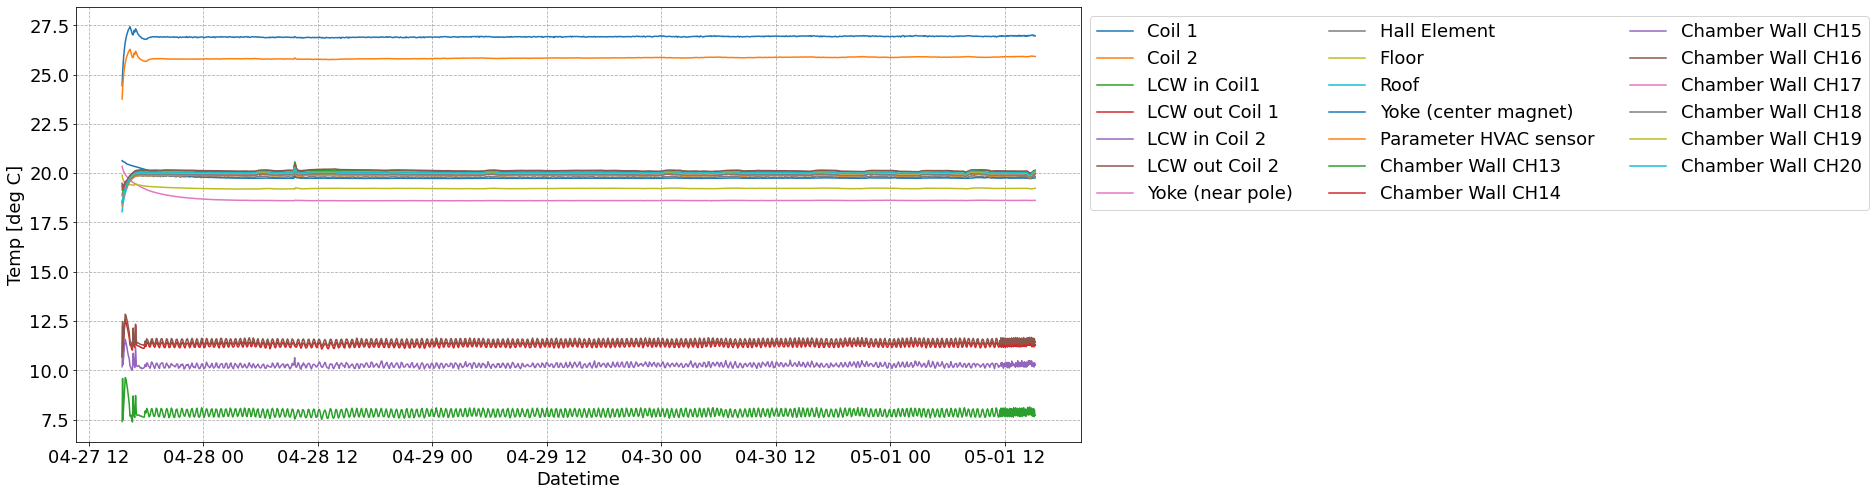

In [48]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[:20]:
    ax.plot(df_temp.index, df_temp[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

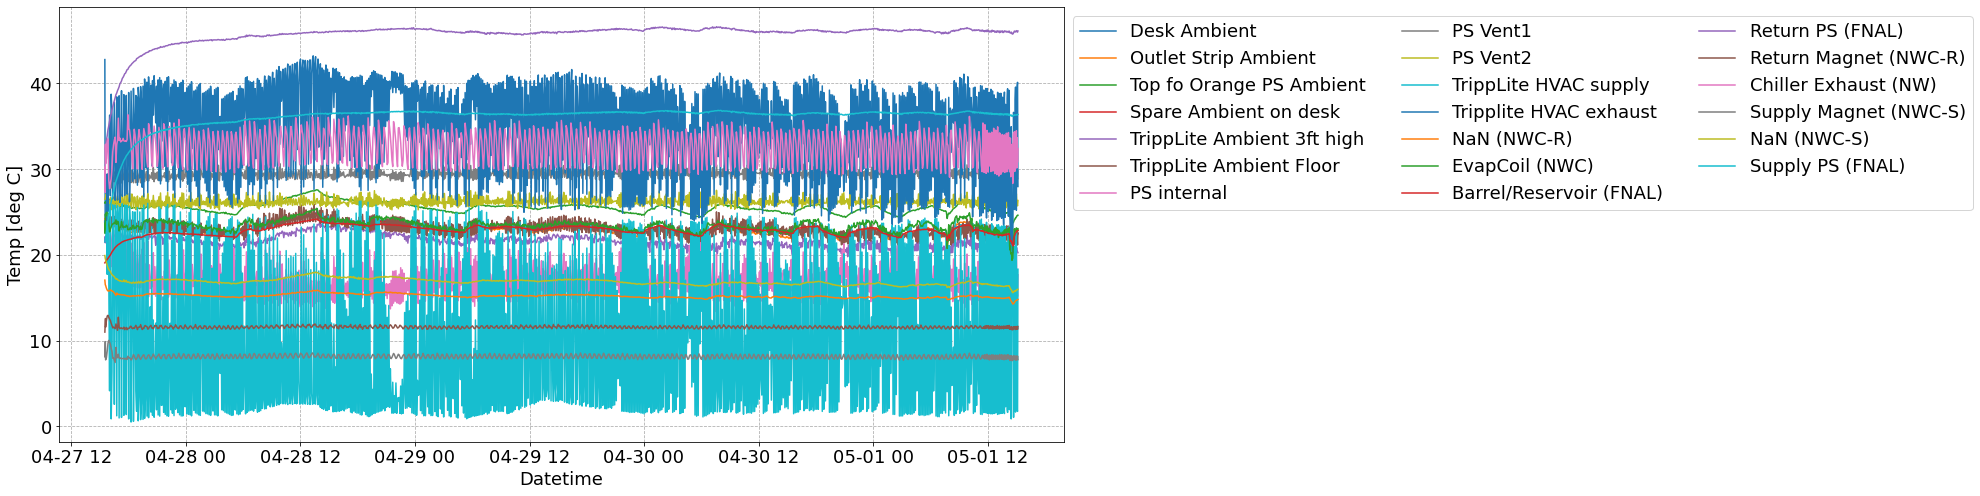

In [49]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[20:]:
    ax.plot(df_temp.index, df_temp[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

In [78]:
# only in the chamber
temps_ch = [a for a in df_temp.columns if ("CH" in a) and int(a[-2:])<21]# or "HVAC" in a]
temps_ch.append("Hall Element")
temps_ch.append("Floor")
temps_ch.append("Roof")
temps_ch.append("Yoke (center magnet)")
temps_ch.append("Yoke (near pole)")
temps_ch.append("Parameter HVAC sensor")

In [80]:
# liquids and coils
temps_liq = [a for a in df_temp.columns if ("LCW" in a) or ("Coil" in a) or ("NW" in a) or ("FNAL" in a)]

In [81]:
temps_liq

['Coil 1',
 'Coil 2',
 'LCW in Coil1',
 'LCW out Coil 1',
 'LCW in Coil 2',
 'LCW out Coil 2',
 'NaN (NWC-R)',
 'EvapCoil (NWC)',
 'Barrel/Reservoir (FNAL)',
 'Return PS (FNAL)',
 'Return Magnet (NWC-R)',
 'Chiller Exhaust (NW)',
 'Supply Magnet (NWC-S)',
 'NaN (NWC-S)',
 'Supply PS (FNAL)']

In [82]:
# all other temps
temps_other = []
for a in df_temp.columns:
    if (a in temps_ch) or (a in temps_liq):
        pass
    else:
        temps_other.append(a)
removals = ["Time", "Magnet Current [A]", "Magnet Voltage [V]", "NMR [T]", "NMR [FFT]", "seconds_delta", "hours_delta", "days_delta"]
for i in removals:
    try:
        temps_other.remove(i)
    except:
        pass

In [83]:
temps_other

['Desk Ambient',
 'Outlet Strip Ambient',
 'Top fo Orange PS Ambient',
 'Spare Ambient on desk',
 'TrippLite Ambient 3ft high',
 'TrippLite Ambient Floor',
 'PS internal',
 'PS Vent1',
 'PS Vent2',
 'TrippLite HVAC supply',
 'Tripplite HVAC exhaust']

In [84]:
df_temp.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1', 'Coil 2',
       'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2', 'LCW out Coil 2',
       'Yoke (near pole)', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Ambient Floor', 'PS internal',
       'PS Vent1', 'PS Vent2', 'TrippLite HVAC supply',
       'Tripplite HVAC exhaust', 'NaN (NWC-R)', 'EvapCoil (NWC)',
       'Barrel/Reservoir (FNAL)', 'Return PS (FNAL)', 'Return Magnet (NWC-R)',
       'Chiller Exhaust (NW)', 'Supply Magnet (NWC-S)', 'NaN (NWC-S)',
       'Supply PS (FNAL)', 'NMR [T]', 'NMR [FFT]', 'seconds_delta',
       'hours_delta',

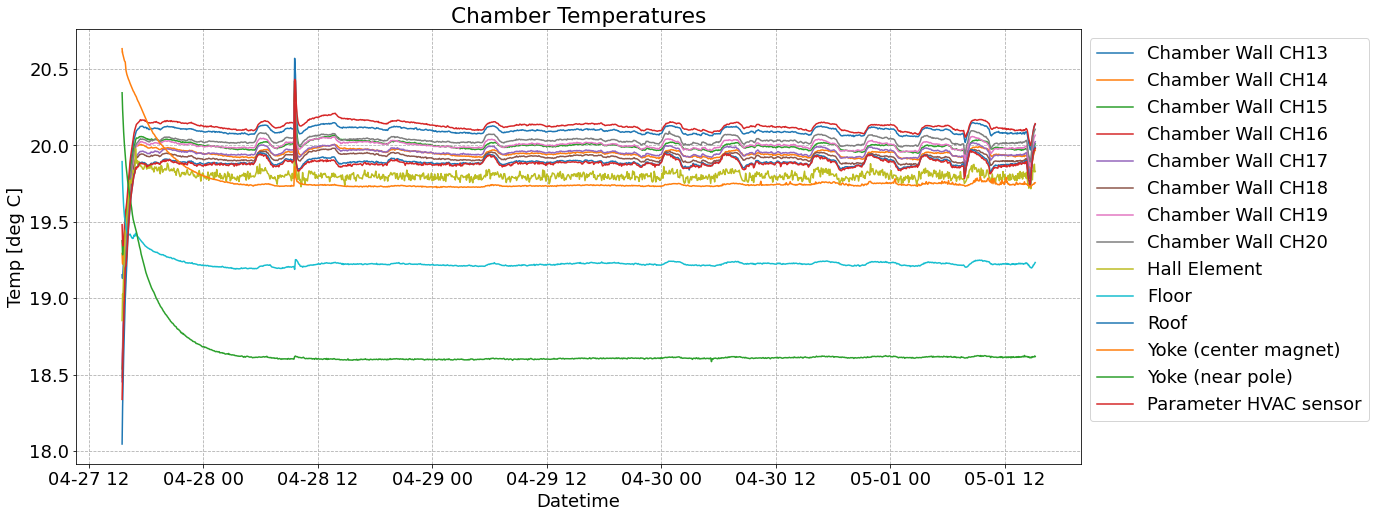

In [85]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_ch:
    ax.plot(df_temp.index, df_temp[c], label=c)

# no Hall probe
# ax.plot(df.index, df[f'{probe}_Cal_T'], label=f'{probe}')
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.set_title('Chamber Temperatures')
ax.legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left');

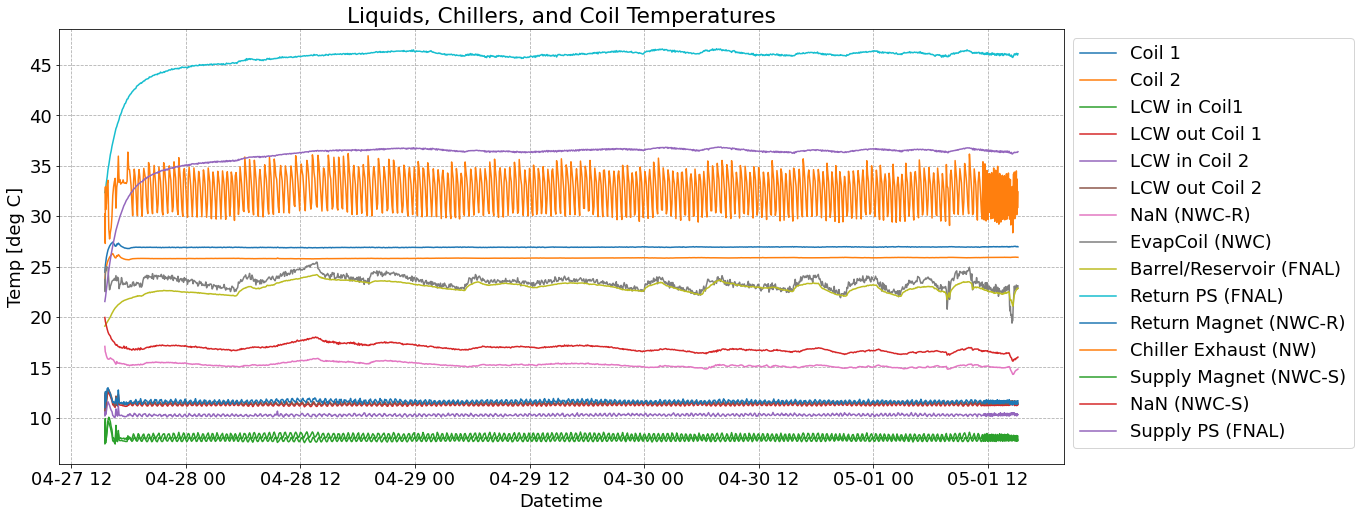

In [87]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_liq:
    ax.plot(df_temp.index, df_temp[c], label=c)

# no Hall probe
# ax.plot(df.index, df[f'{probe}_Cal_T'], label=f'{probe}')
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.set_title('Liquids, Chillers, and Coil Temperatures')
ax.legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left');

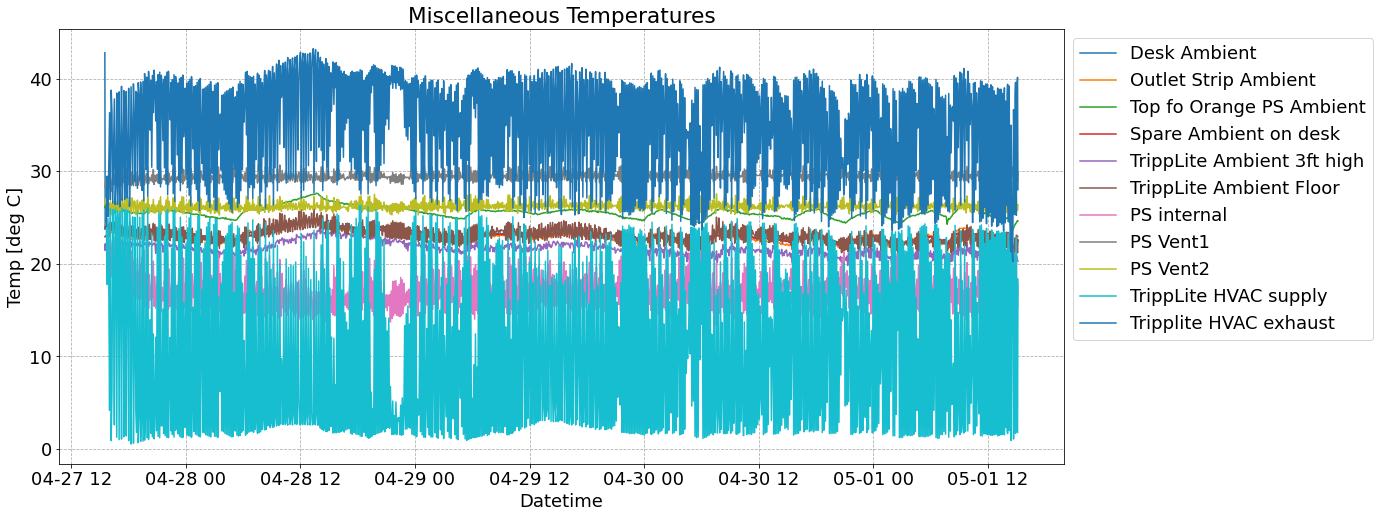

In [92]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_other:
    ax.plot(df_temp.index, df_temp[c], label=c)

# no Hall probe
# ax.plot(df.index, df[f'{probe}_Cal_T'], label=f'{probe}')

ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.set_title('Miscellaneous Temperatures')
ax.legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left');

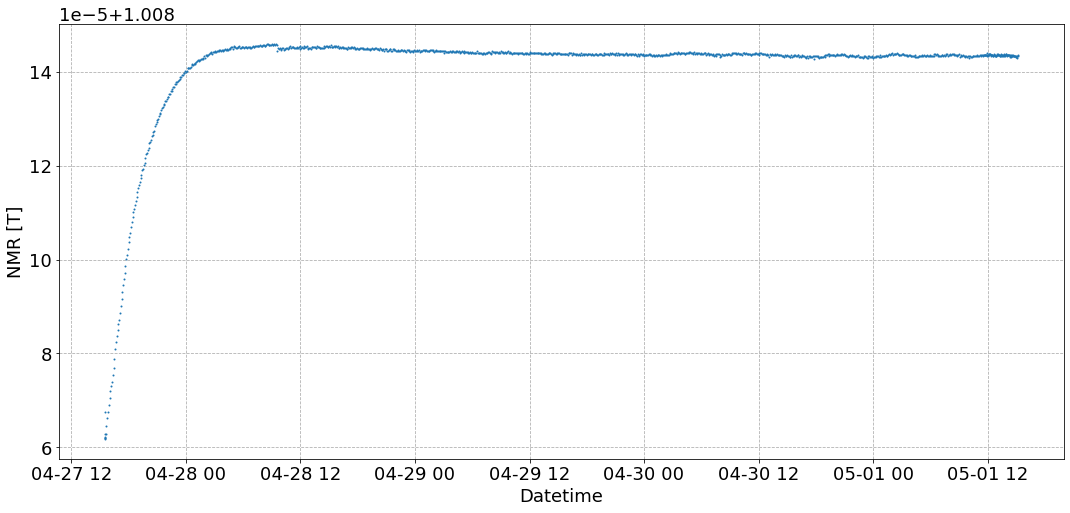

In [52]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.scatter(df_temp.index, df_temp['NMR [T]'], s=1)

ax.set_xlabel('Datetime')
ax.set_ylabel('NMR [T]');

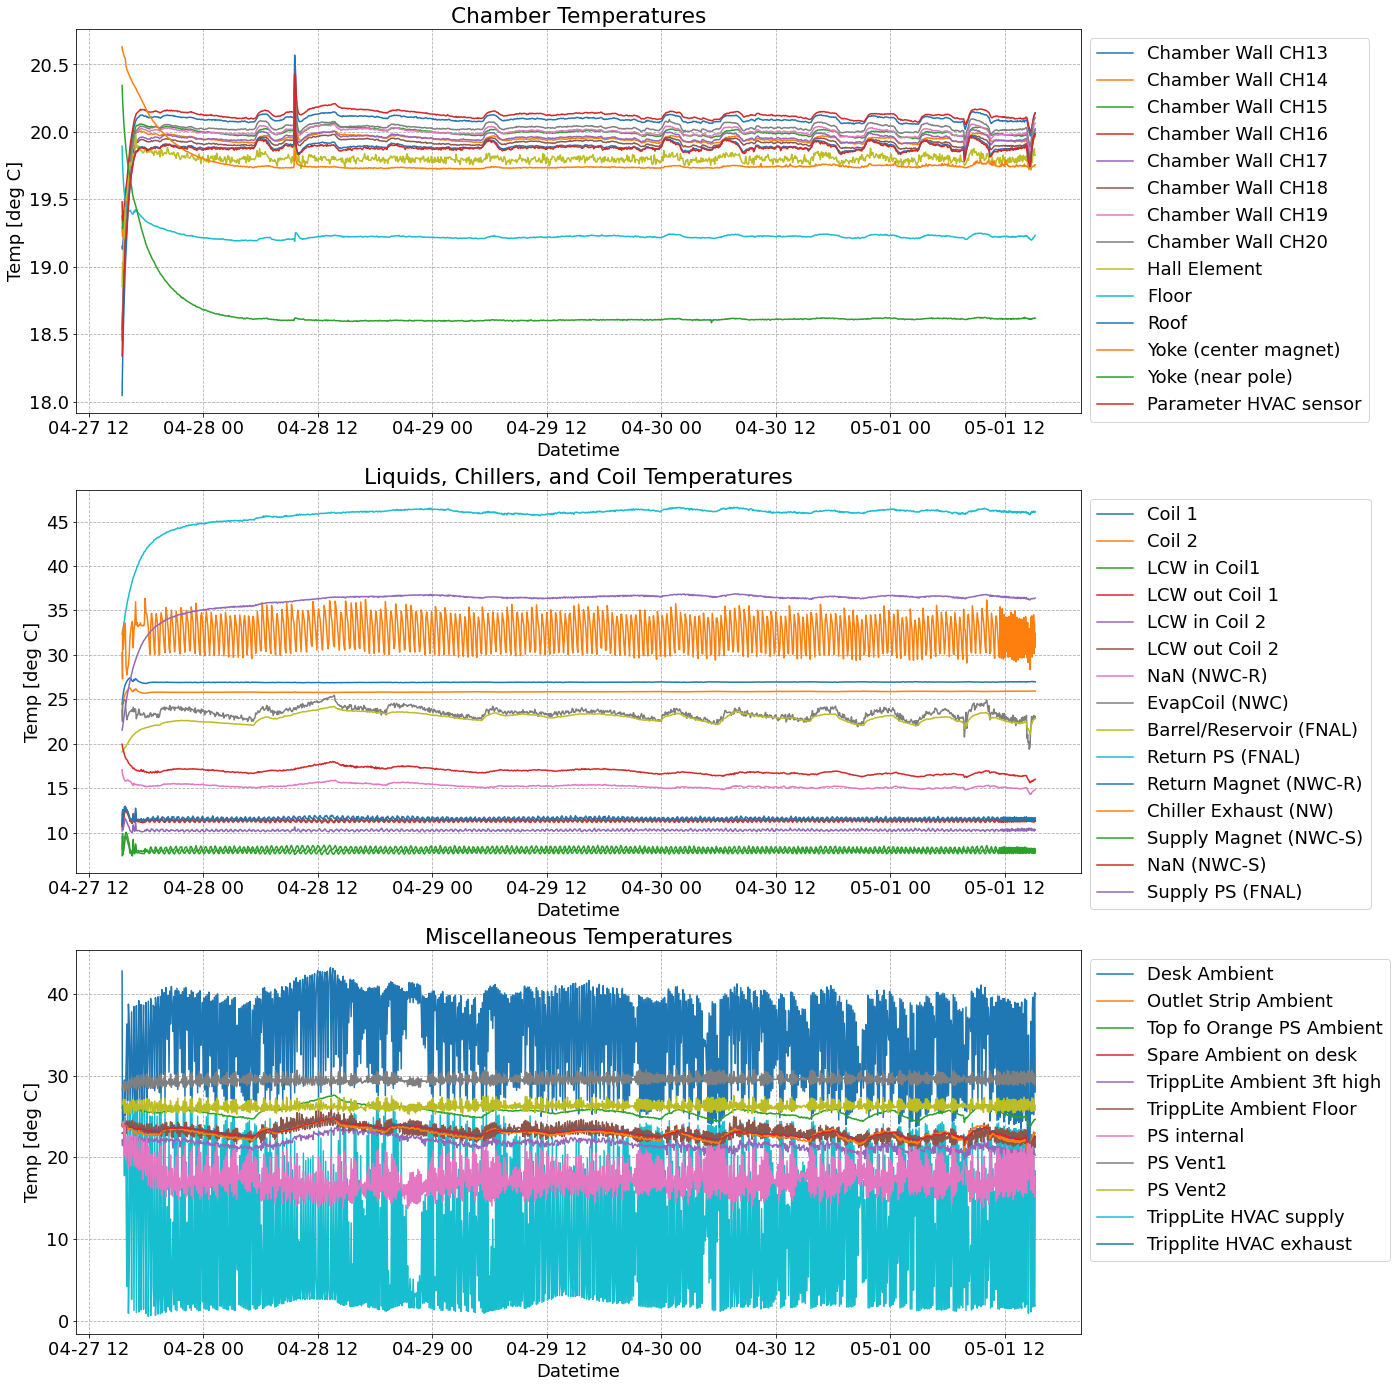

In [95]:
fig, axs = plt.subplots(3, 1, figsize=(18, 24))
# fig = plt.figure(figsize=(18, 24))
# axs = 

for c in temps_ch:
    axs[0].plot(df_temp.index, df_temp[c], label=c)
    
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Temp [deg C]')
axs[0].set_title('Chamber Temperatures')
axs[0].legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left')

for c in temps_liq:
    axs[1].plot(df_temp.index, df_temp[c], label=c)
    
axs[1].set_xlabel('Datetime')
axs[1].set_ylabel('Temp [deg C]')
axs[1].set_title('Liquids, Chillers, and Coil Temperatures')
axs[1].legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left')

for c in temps_other:
    if "Tripp" in c:
        if "HVAC" in c:
            z = 1
        else:
            z = 2
    else:
        z = 3
    axs[2].plot(df_temp.index, df_temp[c], label=c, zorder=z)

axs[2].set_xlabel('Datetime')
axs[2].set_ylabel('Temp [deg C]')
axs[2].set_title('Miscellaneous Temperatures')
axs[2].legend(ncol=1, bbox_to_anchor=(1., 1.), loc='upper left')

In [97]:
B0 = 1.00814
dB = 1e-4

In [122]:
m = df_temp['NMR [T]'] > 1.00814

In [123]:
m.sum()

1092

In [124]:
m_bad = ~m

In [125]:
m_bad.sum()

106

In [126]:
len(df_temp)

1198

In [115]:
df_ = df_temp.copy()

In [116]:
pd.concat([df_, df_])

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-27 15:30:22,4/27/2023 3:30:22 PM,180.538413,20.972683,24.436806,23.755964,7.405327,10.667033,10.181907,10.702753,20.344244,...,11.007594,30.215263,8.132416,19.937170,21.528236,1.008067,0.0,0.0,0.000000,0.000000
2023-04-27 15:31:58,4/27/2023 3:31:58 PM,180.536260,21.009800,24.782085,24.035135,8.704750,11.520616,10.895865,11.690151,20.279003,...,11.787292,27.809345,9.300984,19.704229,21.683973,1.008062,0.0,96.0,0.026667,0.001111
2023-04-27 15:32:29,4/27/2023 3:32:29 PM,180.536317,21.018900,24.877502,24.105854,9.054958,11.782063,11.054657,11.982230,20.265120,...,12.043627,27.599140,9.580857,19.647562,21.731697,1.008062,0.0,127.0,0.035278,0.001470
2023-04-27 15:33:00,4/27/2023 3:33:00 PM,180.536260,21.028533,24.948338,24.181786,9.369321,12.030482,11.242267,12.243223,20.250017,...,12.299884,27.289171,9.900320,19.585241,21.769203,1.008062,0.0,158.0,0.043889,0.001829
2023-04-27 15:33:30,4/27/2023 3:33:30 PM,180.536260,21.045517,25.038607,24.263559,9.584283,12.235582,11.458621,12.476414,20.236231,...,12.543816,32.802383,9.840117,19.551214,21.847912,1.008062,0.0,188.0,0.052222,0.002176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01 15:00:06,5/1/2023 3:00:06 PM,180.532520,21.210017,26.959492,25.919684,8.054966,11.399761,10.359462,11.627370,18.615370,...,11.481969,34.487896,8.223819,15.914075,36.353779,1.008143,0.0,343784.0,95.495556,3.978981
2023-05-01 15:02:36,5/1/2023 3:02:36 PM,180.532577,21.209500,26.984228,25.922752,7.644992,11.182334,10.162072,11.298988,18.616293,...,11.385541,30.142858,7.974544,15.920057,36.331562,1.008143,0.0,343934.0,95.537222,3.980718
2023-05-01 15:05:06,5/1/2023 3:05:06 PM,180.532520,21.209250,26.983126,25.923618,7.982332,11.420622,10.392553,11.589976,18.618786,...,11.657556,33.674954,7.923181,15.953929,36.329746,1.008143,0.0,344084.0,95.578889,3.982454


Text(0.5, 0.98, 'Magnetic Field Measurements & Proxies')

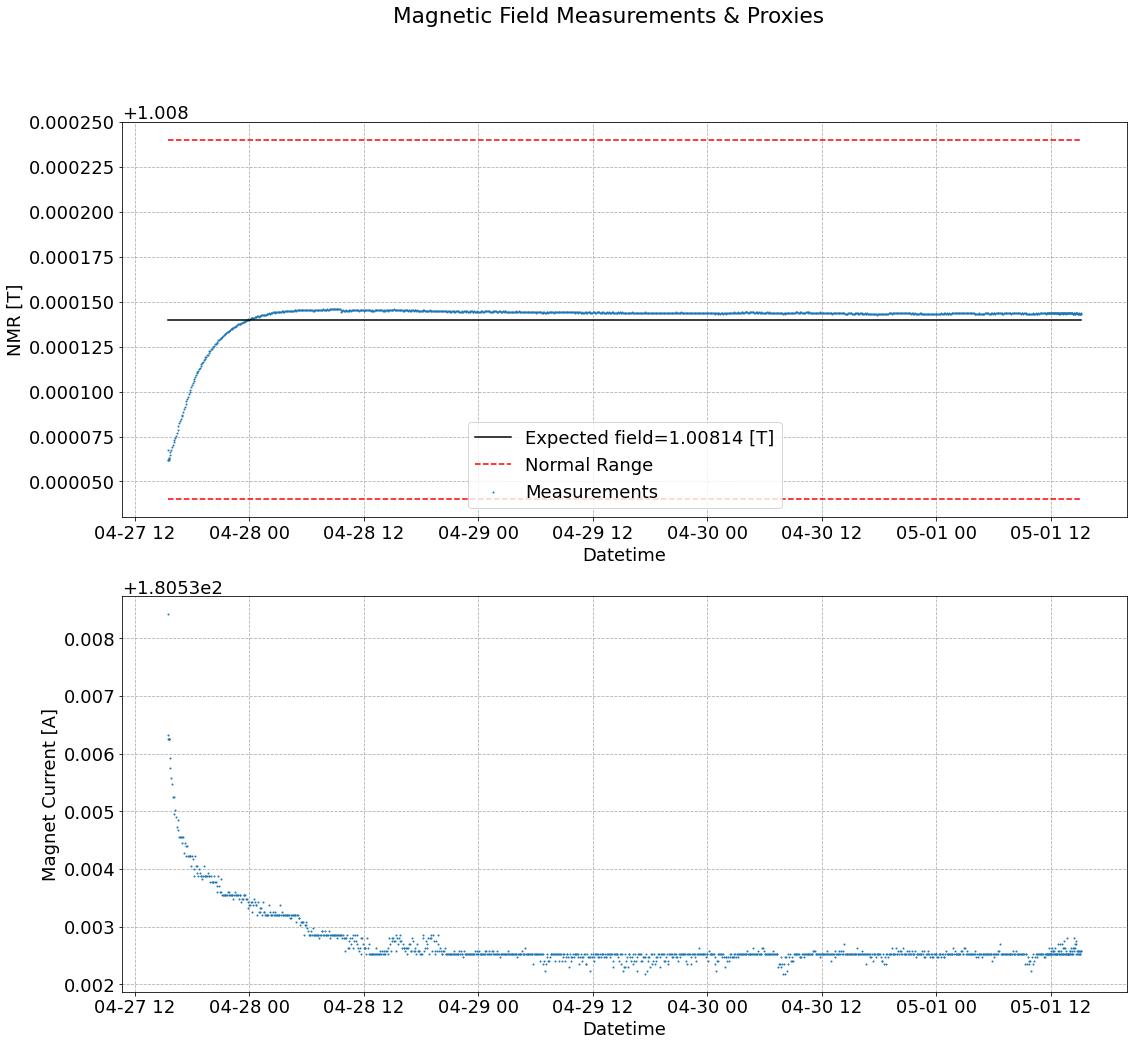

In [100]:
# NMR and magnet current
fig, axs = plt.subplots(2, 1, figsize=(18, 16))

axs[0].plot([df_temp.index[0], df_temp.index[-1]], [B0, B0], 'k-', label=f'Expected field={B0} [T]')
axs[0].plot([df_temp.index[0], df_temp.index[-1]], [B0-dB, B0-dB], 'r--', label='Normal Range')
axs[0].plot([df_temp.index[0], df_temp.index[-1]], [B0+dB, B0+dB], 'r--')

axs[0].scatter(df_temp.index, df_temp['NMR [T]'], s=1, label='Measurements')

axs[0].legend()

axs[1].scatter(df_temp.index, df_temp['Magnet Current [A]'], s=1)

axs[0].set_xlabel('Datetime')
axs[1].set_xlabel('Datetime')
axs[0].set_ylabel('NMR [T]')
axs[1].set_ylabel('Magnet Current [A]')
fig.suptitle('Magnetic Field Measurements & Proxies')

In [101]:
import time

In [107]:
time.time()

1682976219.9951732

In [108]:
import datetime

In [111]:
str(datetime.datetime.now())

'2023-05-01 16:32:10.294337'

In [112]:
datetime.datetime.now()

datetime.datetime(2023, 5, 1, 16, 33, 6, 314444)

In [113]:
datetime.timedelta(hours=2)

datetime.timedelta(seconds=7200)

In [114]:
datetime.datetime.now()-datetime.timedelta(hours=2)

datetime.datetime(2023, 5, 1, 14, 33, 25, 450806)

Text(0.5, 1.0, '|B| Comparisons for Hall Probe: 2F0000000D5EC73A\n')

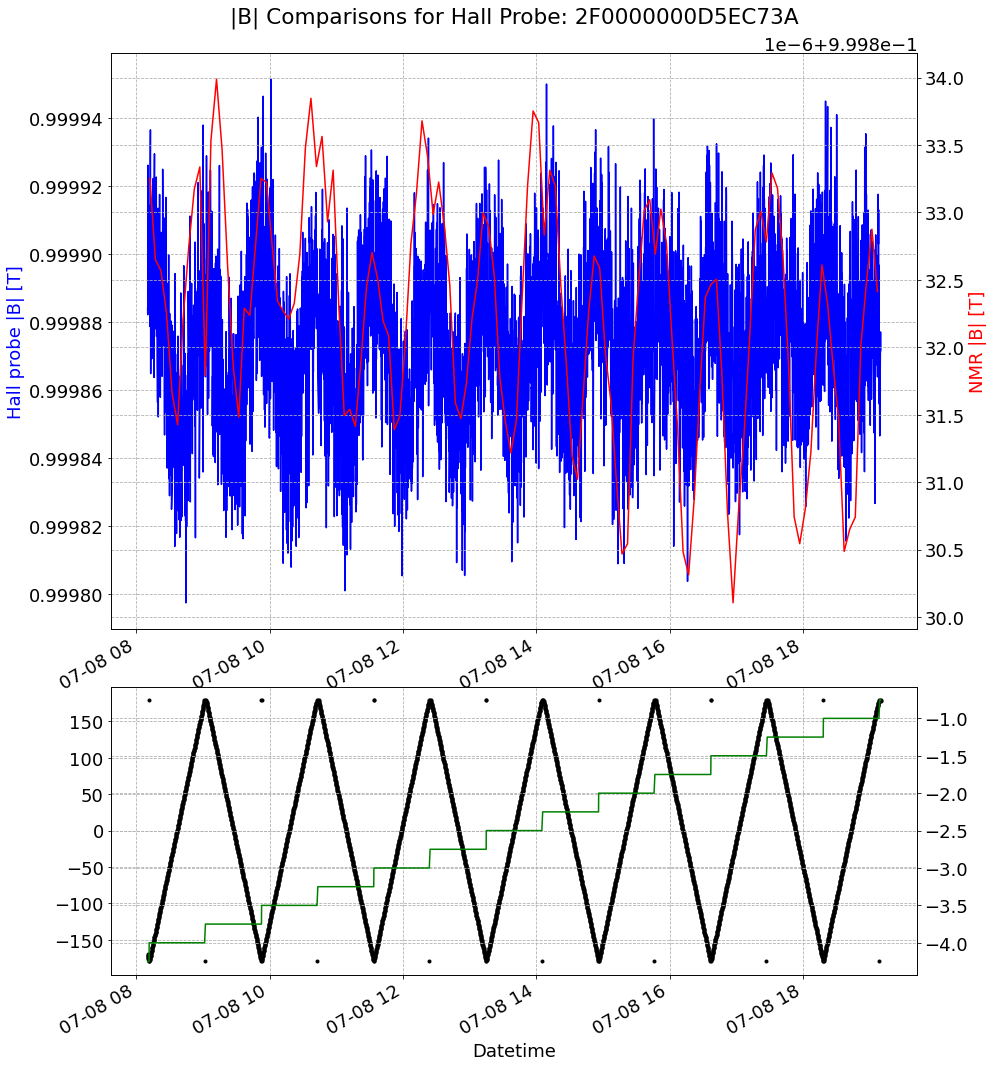

In [82]:
#t0_ = '07-07-22 12:00' # start
# tf_ = '07-10-22 00:00' # end
# t0_ = '07-08-22 16:38'
# tf_ = '07-09-22 03:45'

t0_ = '07-08-22 08:10' # central
tf_ = '07-08-22 19:10' # central
df_ = df.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()
df_t_ = df_t.query(f"'{t0_}' <= Datetime <= '{tf_}'").copy()

fig = plt.figure(figsize=(14, 16))
##ax = plt.subplot(211)
ax = plt.axes([0.1, 0.4, 0.8, 0.5])
#ax2 = plt.subplot(212, sharex=ax)
ax2 = ax.twinx()
ax3 = plt.axes([0.1, 0.1, 0.8, 0.25])
##ax3 = plt.subplot(212, sharex=ax)
ax4 = ax3.twinx()
df_[f'{probe}_Cal_Bmag'].plot(ax=ax, color='blue')
# df_[f'{probe}_Raw_Bmag'].plot(ax=ax, color='blue')
df_t_['NMR [T]'].plot(ax=ax2, color='red')
df_['SmarAct_Meas_Angle_2_Centered'].plot(ax=ax3, color='black', linestyle='None', marker='.')
df_['SmarAct_Meas_Angle_1_Centered'].plot(ax=ax4, color='green')
ax.set_ylabel(f'Hall probe |B| [T]')
ax.yaxis.label.set_color('blue')
ax2.set_ylabel(f'NMR |B| [T]')
ax2.yaxis.label.set_color('red')
ax.set_title(f"|B| Comparisons for Hall Probe: {probe}\n")

In [76]:
-2.5 + 1.5

-1.0

In [78]:
-2.5 - 1.5

-4.0

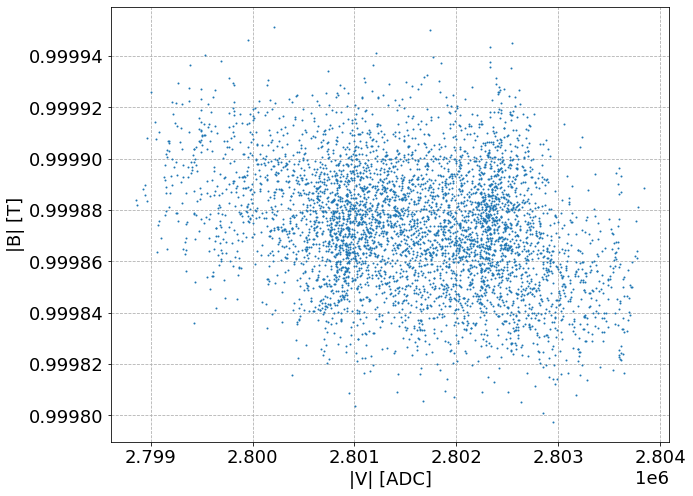

In [88]:
fig, ax = plt.subplots()\

ax.scatter(df_[f'{probe}_Raw_Bmag'], df_[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('|V| [ADC]')
ax.set_ylabel('|B| [T]');

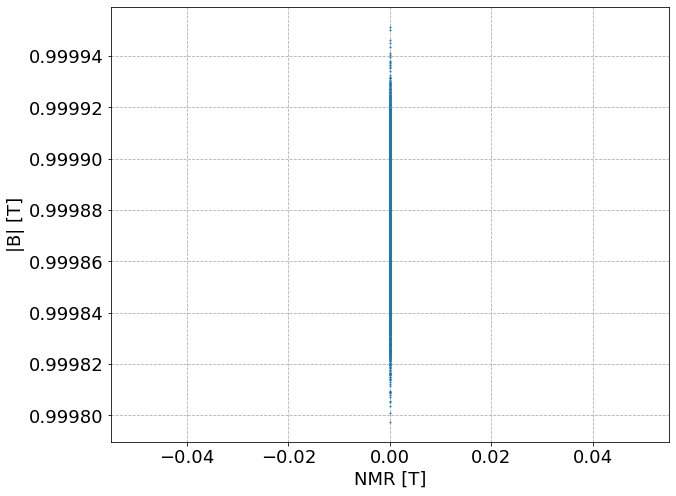

In [89]:
fig, ax = plt.subplots()\

ax.scatter(df_['NMR [T]'], df_[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('NMR [T]')
ax.set_ylabel('|B| [T]');

# Analysis 1: Using Cal Values

# Analysis 2: Using Raw Values